# Image Captioning

Load libraries.

In [1]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from pickle import dump
from pickle import load

from tqdm import tqdm

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions

from tensorflow.keras import layers as lr
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam

from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, SmoothingFunction

In [2]:
from utils1 import *

 Describe paths.


In [3]:
current_path = os.getcwd()

image_dir = current_path + '/data/Flickr8k_Dataset/'
text_dir = current_path + '/data/Flickr8k_text/Flickr8k.token.txt'

train_dir = current_path + '/data/Flickr8k_text/Flickr_8k.trainImages.txt'
valid_dir = current_path + '/data/Flickr8k_text/Flickr_8k.devImages.txt'
test_dir = current_path + '/data/Flickr8k_text/Flickr_8k.testImages.txt'

Load raw document.

In [53]:
raw_document = open(text_dir).read()

Preview part of the document.

In [54]:
raw_document[:500]

'1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .\n1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .\n1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden playhouse .\n1000268201_693b08cb0e.jpg#3\tA little girl climbing the stairs to her playhouse .\n1000268201_693b08cb0e.jpg#4\tA little girl in a pink dress going into a wooden cabin .\n1001773457_577c3a7d70.jpg#0\tA black dog and a spotted dog are fighting\n1001773457_577c3a7'

Create a dataframe.

In [6]:
description = []

for line in raw_document.split('\n'):
    if line != '':
        tokens = line.split('\t')
        img, desc = tokens[0], tokens[1]
        caption_nr = img.split('#')[1]
        img = img.split('.')[0]
        description.append([img]+[caption_nr]+[desc])
        
description_df = pd.DataFrame(description, columns=["filename", "index", "caption"])

In [56]:
description_df.head(7)

,filename,index,caption
0,1000268201_693b08cb0e,0,child in pink dress is climbing up set of stai...
1,1000268201_693b08cb0e,1,girl going into wooden building
2,1000268201_693b08cb0e,2,little girl climbing into wooden playhouse
3,1000268201_693b08cb0e,3,little girl climbing the stairs to her playhouse
4,1000268201_693b08cb0e,4,little girl in pink dress going into wooden cabin
5,1001773457_577c3a7d70,0,black dog and spotted dog are fighting
6,1001773457_577c3a7d70,1,black dog and tricolored dog playing with each...


Print three random images with captions from our dataset.

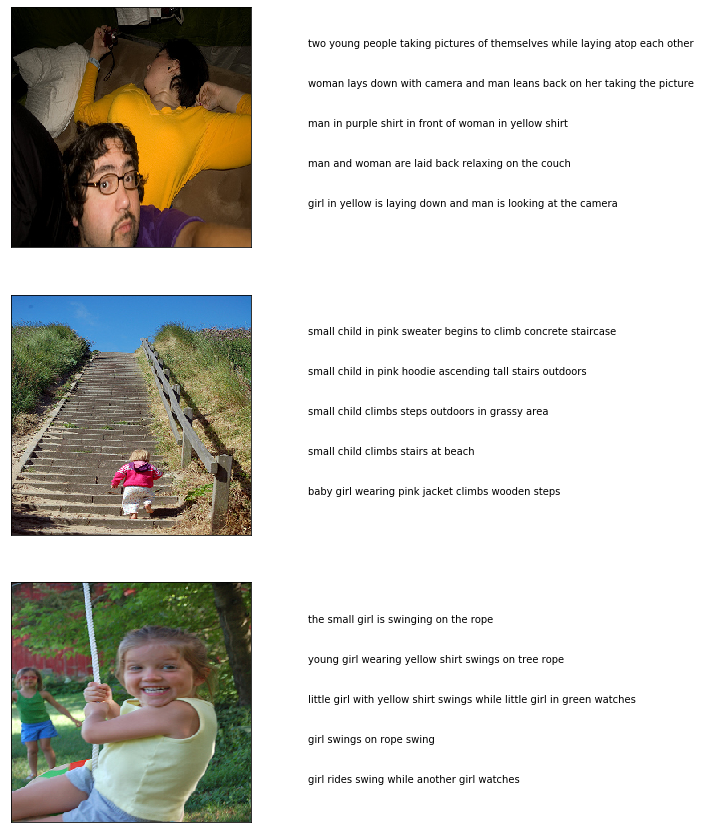

In [55]:
random_3_images(image_dir, description_df)

Cleaning and preparing the inscriptions for later training.

In [9]:
cap_column = description_df.caption.values

for index, text in enumerate(cap_column):
    text = cap_column[index]
    text = text.split()
    text = [word.lower() for word in text]
    text = [word.translate(str.maketrans('','',string.punctuation)) for word in text]
    text = [word for word in text if len(word)>1]
    text = [word for word in text if word.isalpha()]
    cap_column[index] = ' '.join(text)

In [10]:
description_df.head(7)

,filename,index,caption
0,1000268201_693b08cb0e,0,child in pink dress is climbing up set of stai...
1,1000268201_693b08cb0e,1,girl going into wooden building
2,1000268201_693b08cb0e,2,little girl climbing into wooden playhouse
3,1000268201_693b08cb0e,3,little girl climbing the stairs to her playhouse
4,1000268201_693b08cb0e,4,little girl in pink dress going into wooden cabin
5,1001773457_577c3a7d70,0,black dog and spotted dog are fighting
6,1001773457_577c3a7d70,1,black dog and tricolored dog playing with each...


Plot first 30 most freaquent words.

In [59]:
words_count =  count_words(description_df)

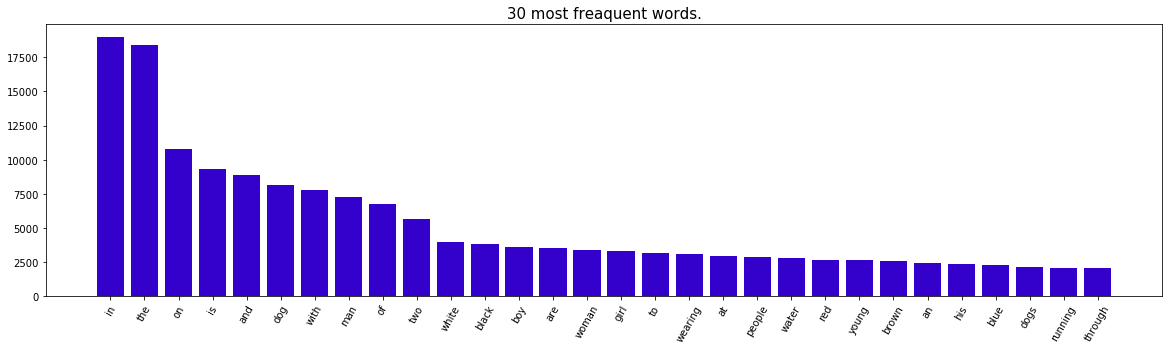

In [58]:
plot_freq_words(words_count.iloc[:30,:], title='30 most freaquent words.')

Saving processed description

In [16]:
temp_lines = []

for image_number, image_caption in zip(description_df.filename, description_df.caption):
    temp_lines.append(image_number + ' ' + image_caption)
    temp_file = '\n'.join(temp_lines)
    file = open(current_path + '/' + 'descriptions.txt', 'w')
    file.write(temp_file)
    file.close()

print('Descriptions saved ...')

Descriptions saved ...


Loading the InceptionV3 model and passing images through it to extract features.

In [17]:
iv3_model = InceptionV3()
iv3_model = Model(inputs=iv3_model.inputs, outputs=iv3_model.layers[-2].output)

features= {}
for name in tqdm(os.listdir(image_dir)):
    filename = os.path.join(image_dir,name)
    image = load_img(filename, target_size=(299,299))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = iv3_model.predict(image, verbose=0)
    image_id = name.split('.')[0]
    features[image_id] = feature

100%|██████████████████████████████████████████████████████████████████████████████| 8091/8091 [06:32<00:00, 20.64it/s]


In [18]:
dump(features, open('features.pkl', 'wb'))
print('Features saved ...')

Features saved ...


Loading training and validation set. 

In the function $\textbf{load_clean_description}$ function we add the 
$\color{#9966CC}{\text{'startseq'}}$ , $\color{#9966CC}{\text{'endseq'}}$ sign to the beginning and end of each sentence, respectively.

In [13]:
train = load_set(train_dir)
train_descriptions = load_clean_descriptions('descriptions.txt', train)
train_features = load_photo_features('features.pkl', train)

valid = load_set(valid_dir)
valid_descriptions = load_clean_descriptions('descriptions.txt', valid)
valid_features = load_photo_features('features.pkl', valid)

print('Train dataset: {}'.format(len(train)))
print('Train descriptions: {}'.format(len(train_descriptions)))
print('Train photos: {}\n'.format(len(train_features)))
print('Valid dataset: {}'.format(len(valid)))
print('Valid descriptions: {}'.format(len(valid_descriptions)))
print('Valid photos: {}'.format(len(valid_features)))

Train dataset: 6000
Train descriptions: 6000
Train photos: 6000

Valid dataset: 1000
Valid descriptions: 1000
Valid photos: 1000


In [14]:
tokenizer = create_tokenizer(train_descriptions)

In [15]:
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)

Vocabulary Size: 7579


In [16]:
dump(tokenizer, open('tokenizer.pkl', 'wb'))
print('Tokenizer saved ...')

Tokenizer saved ...


In [17]:
max_len = max_length(train_descriptions)

Our model

In [18]:
inputs_1 = lr.Input(shape=(2048,))
img = lr.Dropout(0.5)(inputs_1)
img = lr.Dense(256)(img)
img = lr.ReLU()(img)

inputs_2 = lr.Input(shape=(max_len,))
seq = lr.Embedding(input_dim=vocab_size, output_dim=256, mask_zero=True)(inputs_2)
seq = lr.Dropout(0.5)(seq)
seq = lr.LSTM(256,return_sequences=True)(seq)

concatenated = lr.add([img, seq])
x = lr.LSTM(256, return_sequences=True)(concatenated)
x = lr.LSTM(512, return_sequences=False)(x)
x = lr.Dense(vocab_size)(x)
output = lr.Softmax()(x)

model = Model(inputs=[inputs_1, inputs_2], outputs= output)
model.compile(loss='categorical_crossentropy', optimizer=Adam())
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_1[0][0]                    
__________________________________________________________________________________________________
embedding (Embedding)           (None, 34, 256)      1940224     input_2[0][0]                    
______________________________________________________________________________________________

In [19]:
X_train_img, X_train_text, Y_train_text = [], [], []

for key, cap_list in train_descriptions.items():
    for cap in cap_list:
        seq = tokenizer.texts_to_sequences([cap])[0]
        for i in range(1, len(seq)):
            seq_in, seq_out = seq[:i], seq[i]
            seq_in = pad_sequences([seq_in], maxlen=max_len)[0]
            seq_out = to_categorical([seq_out], num_classes=vocab_size)[0]
            X_train_img.append(train_features[key][0])
            X_train_text.append(seq_in)
            Y_train_text.append(seq_out)
            
X_train_img = np.array(X_train_img) 
X_train_text = np.array(X_train_text)
Y_train_text = np.array(Y_train_text)

In [20]:
X_valid_img, X_valid_text, Y_valid_text = [], [], []

for key, cap_list in valid_descriptions.items():
    for cap in cap_list:
        seq = tokenizer.texts_to_sequences([cap])[0]
        for i in range(1, len(seq)):
            seq_in, seq_out = seq[:i], seq[i]
            seq_in = pad_sequences([seq_in], maxlen=max_len)[0]
            seq_out = to_categorical([seq_out], num_classes=vocab_size)[0]
            X_valid_img.append(valid_features[key][0])
            X_valid_text.append(seq_in)
            Y_valid_text.append(seq_out)
            
X_valid_img = np.array(X_valid_img) 
X_valid_text = np.array(X_valid_text)
Y_valid_text = np.array(Y_valid_text)

In [21]:
earlystopping = EarlyStopping(monitor='val_loss', verbose=1,  patience=5, mode='min')

In [22]:
history = model.fit(
    [X_train_img, X_train_text], 
    Y_train_text, 
    epochs=10,
    batch_size=512, 
    verbose=1, 
    callbacks=[earlystopping], 
    validation_data=([X_valid_img, X_valid_text], Y_valid_text)
)

model.save('modelIV3.h5')

Train on 306404 samples, validate on 50903 samples
Epoch 1/10
306404/306404 [==============================] - 245s 798us/sample - loss: 5.4449 - val_loss: 4.8388
Epoch 2/10
306404/306404 [==============================] - 280s 915us/sample - loss: 4.4258 - val_loss: 4.0589
Epoch 3/10
306404/306404 [==============================] - 312s 1ms/sample - loss: 3.8185 - val_loss: 3.7539
Epoch 4/10
306404/306404 [==============================] - 323s 1ms/sample - loss: 3.4952 - val_loss: 3.6169
Epoch 5/10
306404/306404 [==============================] - 333s 1ms/sample - loss: 3.2696 - val_loss: 3.5432
Epoch 6/10
306404/306404 [==============================] - 347s 1ms/sample - loss: 3.0942 - val_loss: 3.5005
Epoch 7/10
306404/306404 [==============================] - 339s 1ms/sample - loss: 2.9467 - val_loss: 3.4873
Epoch 8/10
306404/306404 [==============================] - 342s 1ms/sample - loss: 2.8163 - val_loss: 3.4813
Epoch 9/10
306404/306404 [==============================] - 336s 

Plot of a training process.

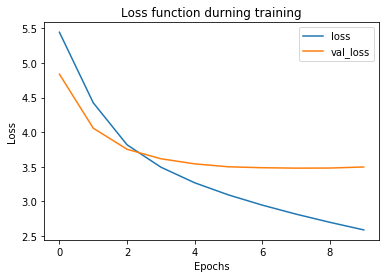

In [60]:
for label in ["loss","val_loss"]:
    plt.plot(history.history[label],label=label)
plt.legend()
plt.title('Loss function durning training')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

### Model evaluation 

Loading trained model and test set.

In [ ]:
model = load_model('modelIV3.h5')

In [24]:
test = load_set(test_dir)
test_descriptions = load_clean_descriptions('descriptions.txt', test)
test_features = load_photo_features('features.pkl', test)

print('Test dataset: {}'.format(len(test)))
print('Test descriptions: {}'.format(len(test_descriptions)))
print('Test photos: {}'.format(len(test_features)))

Test dataset: 1000
Test descriptions: 1000
Test photos: 1000


In [29]:
list_of_references, predicted = [], []

for key, captions_list in tqdm(test_descriptions.items()):
    y_hat = generate_description(model, tokenizer, test_features[key], max_len)
    y_hat = clean_summary(y_hat)
    references = [clean_summary(x).split() for x in captions_list]
    list_of_references.append(references)
    predicted.append(y_hat.split())
    
print('BLEU 1: {}'.format(corpus_bleu(list_of_references, predicted, weights=(1.0, 0, 0, 0))))
print('BLEU 2: {}'.format(corpus_bleu(list_of_references, predicted, weights=(0.5, 0.5, 0, 0))))
print('BLEU 3: {}'.format(corpus_bleu(list_of_references, predicted, weights=(0.3, 0.3, 0.3, 0))))
print('BLEU 4: {}'.format(corpus_bleu(list_of_references, predicted, weights=(0.25, 0.25, 0.25, 0.25))))

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [20:23<00:00,  1.22s/it]


BLEU 1: 0.513369616658779
BLEU 2: 0.3233810326570559
BLEU 3: 0.23765974567705858
BLEU 4: 0.12417254505047189


In [32]:
pred_good, pred_bad, bleus = [], [], []

for key, desc_list in tqdm(test_descriptions.items()):
    yhat = generate_description(model, tokenizer, test_features[key], max_len)
    yhat = clean_summary(yhat).split()
    references = [clean_summary(d).split() for d in desc_list]
    bleu = sentence_bleu(references, yhat, smoothing_function=SmoothingFunction().method1)
    bleus.append(bleu)
    
    if bleu > 0.75 and len(pred_good) < 5:
        pred_good.append((bleu, key, references, yhat))
    elif bleu < 0.25 and len(pred_bad) < 5:
        pred_bad.append((bleu, key, references, yhat))

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [22:00<00:00,  1.32s/it]


## Bad prediction.

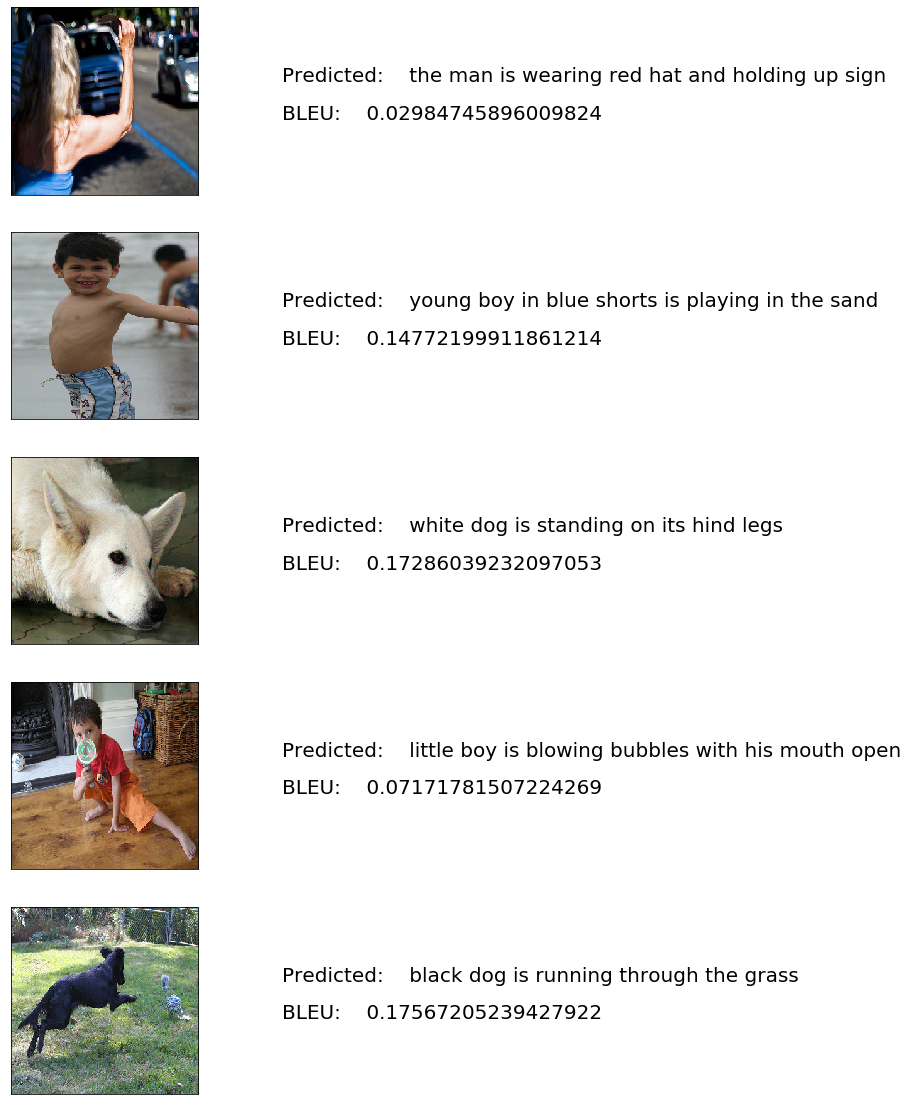

In [61]:
plot_pred(pred_bad, image_dir)

## Good predictions.

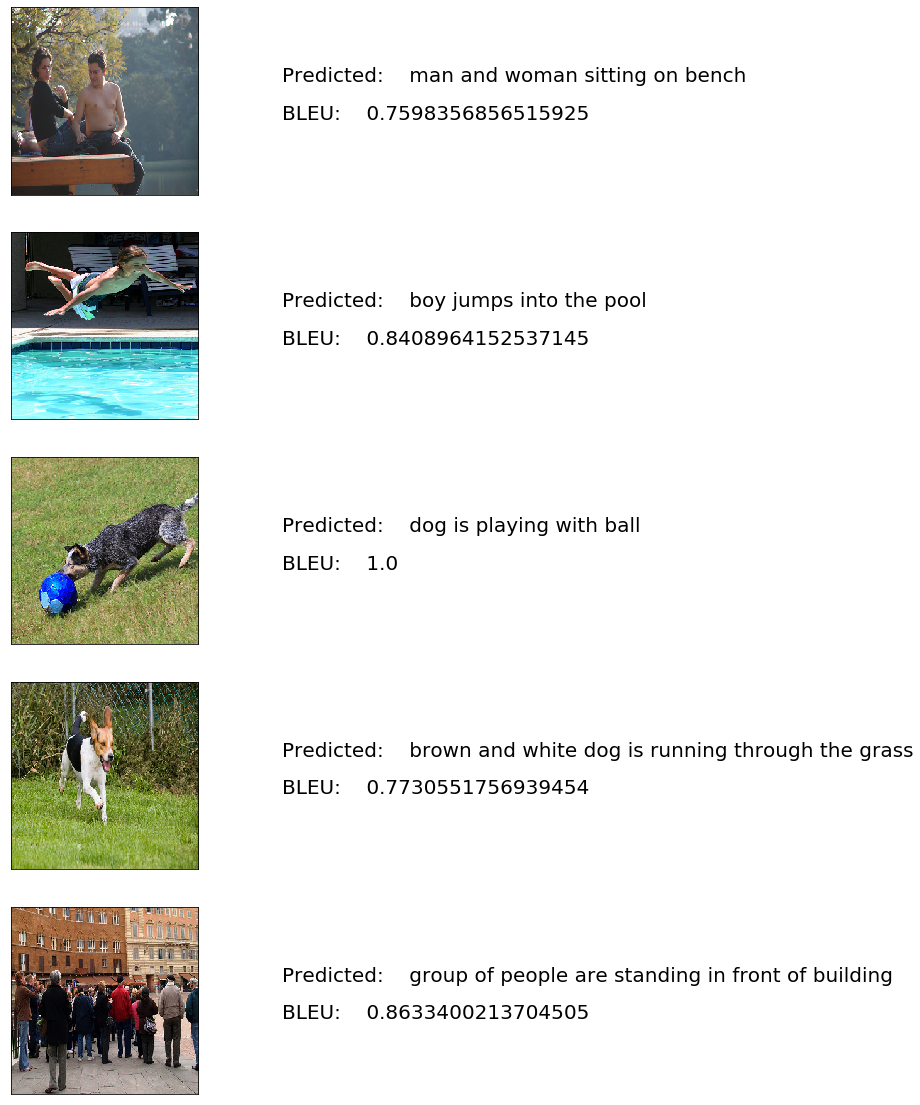

In [62]:
plot_pred(pred_good, image_dir)